# Projet 06 : Classifiez automatiquement des biens de consommation
# Transfer Learning

Le Transfer Learning, ou apprentissage par transfert en français, désigne l’ensemble des méthodes qui permettent de transférer les connaissances acquises à partir de la résolution de problèmes donnés pour traiter un autre problème. 

Le Transfer Learning a connu un grand succès avec l’essor du Deep Learning.  En effet, bien souvent, les modèles utilisés dans ce domaine nécessitent des temps de calcul élevés et des ressources importantes. Or, en utilisant des modèles pré-entraînés comme point de départ, le Transfer Learning permet de développer rapidement des modèles performants et résoudre efficacement des problèmes complexes en Computer Vision ou Natural Language Processing, NLP.


### Librairies

In [1]:
# Classic Lib.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

# PCA & Classifier.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Computer Vision Lib.
import cv2
import PIL

# Clustering.
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Error & Quality of prediction.
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Deep Learning & Transfer Learning.
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import Sequential, optimizers

### Options

In [2]:
# Format & option.
sns.set(rc={'figure.figsize':(16,9)})
pd.options.display.max_columns = 50

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

### Import du DataFrame

In [3]:
use_colab = True 

if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path ='/content/drive/MyDrive/'
else:
    path='/data/'

Mounted at /content/drive


In [4]:
# Import the dataset.
df_product = pd.read_csv(path + 'data_embedding.csv')

In [5]:
df_product.head(4)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category,product_category2
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen


In [52]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
def reduce_space(a):
    """
    Cette fonction retire le dernier caractère du str en entré.
    """
    
    size = len(a)
    
    return a[:size-1]    

In [7]:
# Enlève un espace dans les str de la colonne product_category.
df_product['product_category'] = df_product['product_category'].apply(lambda x:reduce_space(x))

### **Chargement** & **Filtrage** des images

In [8]:
# Path du dossier.

folder = (path + "Images")

features_bis = []
images = []

# Chargement des images en noir & blanc.
for filename in os.listdir(folder):
    
    # Path du fichier.
    path = folder + '/' + filename
    
    img = load_img(str(path),target_size=(224, 224))
    
    images.append(img)
    
    

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


### Mise en place du modèle

In [10]:
 model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553476096/553467096 [==============================] - 4s 0us/step


On utilise une boucle 'for' pour appliquer notre modèle sur chaque image du
DataFrame et on stocke ensuite les données entrainées dans 'features_bis'.

In [11]:
for img in images:
    
    # Ajout de l'image filtrée à la liste des images.
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
   
    # get extracted features
    features = model.predict(img)
    features_bis.append(features)

In [12]:
len(features_bis)

1050

### Réduction de dimension PCA 

On reshape notre DataFrame 'X' afin qu'il puisse rentrer dans notre réduction 
de dimension PCA.

In [14]:
X = features_bis
X = np.array(X)

In [20]:
X= X.reshape(X.shape[0], (X.shape[1]*X.shape[2]))

In [21]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Ysklearn = sklearn_pca.fit_transform(X)

sklearn_pca.explained_variance_ratio_

array([0.08030896, 0.06496254], dtype=float32)

In [22]:
Ysklearn

array([[  1.7922994, -13.243489 ],
       [-29.982758 , -40.435474 ],
       [ 16.57223  ,  -4.176918 ],
       ...,
       [ 30.874447 , -13.579715 ],
       [  2.1910963,  -6.371767 ],
       [ 49.01226  ,  -5.894514 ]], dtype=float32)

In [23]:
Y_sklearn = pd.DataFrame(Ysklearn,columns = ['Column_A','Column_B'])

In [24]:
Y_sklearn

,Column_A,Column_B
0,1.792299,-13.243489
1,-29.982758,-40.435474
2,16.572229,-4.176918
3,1.120261,28.277475
4,23.746456,-12.188632
...,...,...
1045,49.069138,-6.919233
1046,-3.916775,8.203435
1047,30.874447,-13.579715
1048,2.191096,-6.371767


## Clustering : on effectue un clustering KMeans

In [25]:
km = KMeans(n_clusters=7, 
            init='k-means++',
            random_state=2)
km.fit(Y_sklearn)

KMeans(n_clusters=7, random_state=2)

In [26]:
Y_sklearn['Labels_KM'] = km.labels_
Y_sklearn['Categ'] = df_product.product_category
Y_sklearn.groupby('Labels_KM').size()

Labels_KM
0    207
1     94
2    134
3    181
4    230
5     65
6    139
dtype: int64

In [27]:
for col in Y_sklearn.columns:
    print(col)

Column_A
Column_B
Labels_KM
Categ


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Visualisation ACP avec KMeans')

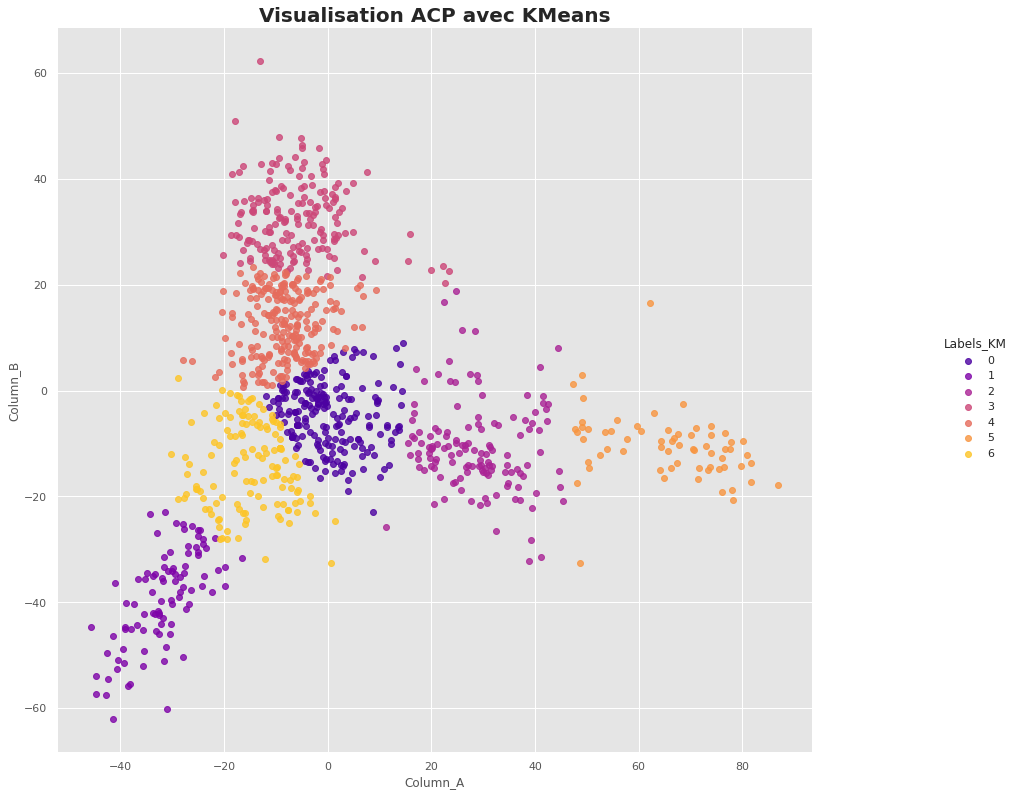

In [28]:
sns.lmplot(x='Column_A', 
            y='Column_B', 
            hue='Labels_KM', 
            data= Y_sklearn ,
            palette = 'plasma',
            fit_reg=False,
            legend=True, 
            legend_out=True)

plt.gcf().set_size_inches(16, 12)
plt.title('Visualisation ACP avec KMeans',size=20, weight='bold')

In [29]:
Y_sklearn['Labels'] = km.labels_

In [30]:
Y_sklearn

,Column_A,Column_B,Labels_KM,Categ,Labels
0,1.792299,-13.243489,0,Home Furnishing,0
1,-29.982758,-40.435474,1,Baby Care,1
2,16.572229,-4.176918,2,Baby Care,2
3,1.120261,28.277475,3,Home Furnishing,3
4,23.746456,-12.188632,2,Home Furnishing,2
...,...,...,...,...,...
1045,49.069138,-6.919233,5,Baby Care,5
1046,-3.916775,8.203435,4,Baby Care,4
1047,30.874447,-13.579715,2,Baby Care,2
1048,2.191096,-6.371767,0,Baby Care,0


On observe que l'ARI est faible et que le coefficient de silouhette a un score de 0.42, on en conclut que le modèle n'est pas très performant ici.

In [31]:
# Indice de Rand ajusté.
adjusted_rand_score(Y_sklearn.Labels,Y_sklearn.Categ)

-0.00017223355595891214

In [49]:
Y_sklearn_bis = Y_sklearn.drop(columns=['Categ'])

In [50]:
Y_sklearn_bis

,Column_A,Column_B,Labels_KM,Labels
0,1.792299,-13.243489,0,0
1,-29.982758,-40.435474,1,1
2,16.572229,-4.176918,2,2
3,1.120261,28.277475,3,3
4,23.746456,-12.188632,2,2
...,...,...,...,...
1045,49.069138,-6.919233,5,5
1046,-3.916775,8.203435,4,4
1047,30.874447,-13.579715,2,2
1048,2.191096,-6.371767,0,0


In [51]:
# Coefficient de silhouette moyen.
silhouette_score(Y_sklearn_bis, Y_sklearn.Labels)

0.42445096127214343